In [3]:
from urllib.request import urlopen
import json
from collections import defaultdict
import os
import mysql
import mysql.connector
from tqdm import tqdm
import json
from time import time
import ipinfo
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def get_mysql_connection():
    return mysql.connector.connect(
        host="play.turinggame.ai",
        user="game",
        password="mp8sa841j1xGFkOhtHzhitUx383KL2WV",
        database="turinggame"
    )

def fetch_all(query: str, params = None, dictionary=True) -> dict:
    conn = get_mysql_connection()
    cursor = conn.cursor(dictionary=dictionary)
    cursor.execute(query, params)
    result = cursor.fetchall()
    conn.commit()
    cursor.close()
    conn.close()
    return result

In [5]:
with open("data/counted_countries_distinct_by_user_id.json") as json_file:
    country_data = json.load(json_file)

print(len(country_data))

64


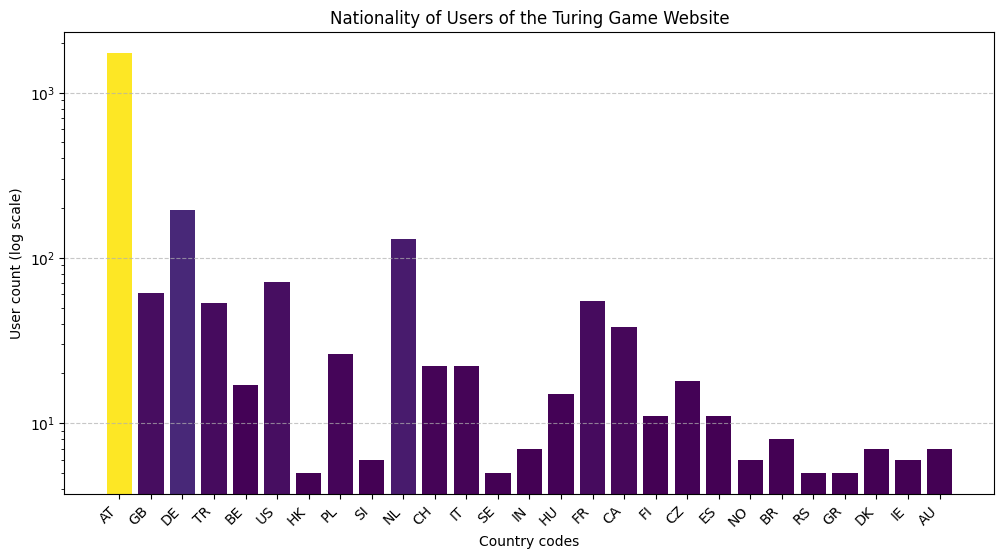

In [97]:
with open("data/counted_countries_distinct_by_user_id.json") as json_file:
    country_data = json.load(json_file)

countries = list(country_data.keys())
users = list(country_data.values())


for i in range(len(users) - 1, -1, -1):
    if users[i] < 5:
        users.pop(i)
        countries.pop(i)


plt.figure(figsize=(12, 6))
norm = plt.Normalize(min(users), max(users))
colors = plt.cm.viridis(norm(users))

plt.bar(countries, users, color=colors)

plt.xticks(rotation=45, ha="right")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.yscale("log")

plt.xlabel("Country codes")
plt.ylabel("User count (log scale)")
plt.title("Nationality of Users of the Turing Game Website")

plt.show()


In [8]:
print(f"CA: {country_data["CA"]}")
print(f"US: {country_data["US"]}")
print(f"CN: {country_data["CN"]}")
print(f"HK: {country_data["HK"]}")
print(f"AU: {country_data["AU"]}")
print(f"NZ: {country_data["NZ"]}")
print(f"BR: {country_data["BR"]}")
print(f"AT: {country_data["AT"]}")

CA: 38
US: 71
CN: 2
HK: 5
AU: 7
NZ: 2
BR: 8
AT: 1740


In [63]:
query = """
WITH session_counts AS (
    SELECT userID, COUNT(sessionID) AS session_count
    FROM sessions
    WHERE starttime <= '2025-03-14 13:30:00'
    GROUP BY userID
),
total_users AS (
    SELECT COUNT(userID) AS total_users_count
    FROM session_counts
)
SELECT 
    CASE
        WHEN session_count = 1 THEN 'Only 1 session'
        WHEN session_count BETWEEN 2 AND 5 THEN 'Between 2 to 5 sessions'
        WHEN session_count BETWEEN 6 AND 10 THEN 'Between 6 to 10 sessions'
        WHEN session_count > 10 THEN 'More than 10 sessions'
    END AS session_group,
    COUNT(userID) AS user_count, 
    (COUNT(userID) * 100.0 / (SELECT total_users_count FROM total_users)) AS percentage
FROM session_counts
GROUP BY session_group
ORDER BY session_group;
"""
session_data = fetch_all(query, dictionary=False)

Text(0.5, 1.0, 'Percentage of Repeat Sessions (total user: 1773)')

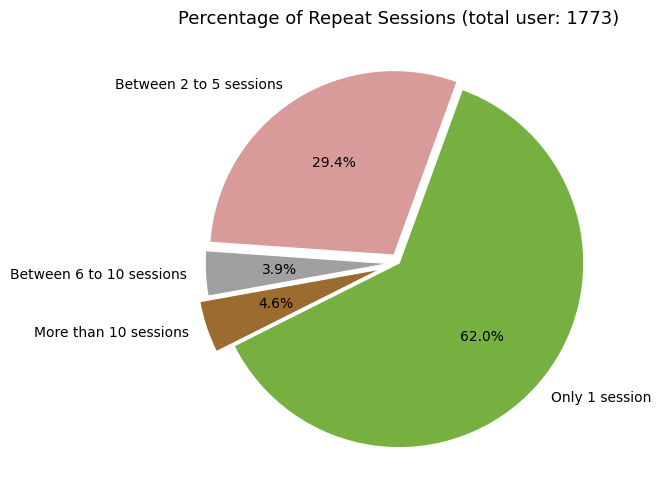

In [79]:
labels = [row[0] for row in session_data]
sizes = [row[1] for row in session_data]
percentage = [row[2] for row in session_data]
colors = ['#D99A9A', '#A0A0A0', '#9C6B30', '#76B041']  # Muted but distinct colors
explode = (0.05, 0.05, 0.1, 0)  # Slightly separate smaller slices for emphasis

plt.figure(figsize=(6, 6))  # Balanced figure size
plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', colors=colors,
    explode=explode, startangle=70,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title(f"Percentage of Repeat Sessions (total user: {sum(sizes)})", fontsize=13)

In [80]:
print(labels)
print(sizes)

['Between 2 to 5 sessions', 'Between 6 to 10 sessions', 'More than 10 sessions', 'Only 1 session']
[522, 70, 81, 1100]


In [83]:
query = """
WITH session_counts AS (
    SELECT userID, COUNT(sessionID) AS session_count
    FROM sessions
    WHERE starttime <= '2025-03-14 13:30:00'
    GROUP BY userID
),
one_session_users AS (
    SELECT userID 
    FROM session_counts
    WHERE session_count = 1
),
played_games AS (
    SELECT DISTINCT gp.userID
    FROM gameplayers gp
    JOIN one_session_users osu ON gp.userID = osu.userID
)
SELECT 
    COUNT(osu.userID) AS "Total",
    COUNT(pg.userID) AS "with_game",
    (COUNT(pg.userID) * 100.0 / NULLIF(COUNT(osu.userID), 0)) AS percentage
FROM one_session_users osu
LEFT JOIN played_games pg ON osu.userID = pg.userID;
"""
played_one_game_percentage = fetch_all(query, dictionary=True)[0]
print(f"{played_one_game_percentage["with_game"]} one session players played at least one game corresponding to {played_one_game_percentage["percentage"]:.2f}")

305 one session players played at least one game corresponding to 27.73


In [90]:
query = """
WITH session_counts AS (
    SELECT userID, COUNT(sessionID) AS session_count
    FROM sessions
    WHERE starttime <= '2025-03-14 13:30:00'
    GROUP BY userID
),
one_session_users AS (
    SELECT userID 
    FROM session_counts
    WHERE session_count > 10
),
played_games AS (
    SELECT DISTINCT gp.userID
    FROM gameplayers gp
    JOIN one_session_users osu ON gp.userID = osu.userID
)
SELECT 
    COUNT(osu.userID) AS "Total",
    COUNT(pg.userID) AS "with_game",
    (COUNT(pg.userID) * 100.0 / NULLIF(COUNT(osu.userID), 0)) AS percentage
FROM one_session_users osu
LEFT JOIN played_games pg ON osu.userID = pg.userID;
"""
played_one_game_percentage = fetch_all(query, dictionary=True)[0]
print(f"{played_one_game_percentage["with_game"]} above 10 session players played at least one game corresponding to {played_one_game_percentage["percentage"]:.2f}")

54 above 10 session players played at least one game corresponding to 66.67


In [95]:
query = """
WITH session_counts AS (
    SELECT userID, COUNT(sessionID) AS session_count
    FROM sessions
    WHERE starttime <= '2025-03-14 13:30:00'
    GROUP BY userID
),
one_session_users AS (
    SELECT userID 
    FROM session_counts
    WHERE session_count > 25
),
played_games AS (
    SELECT DISTINCT gp.userID
    FROM gameplayers gp
    JOIN one_session_users osu ON gp.userID = osu.userID
)
SELECT 
    COUNT(osu.userID) AS "Total",
    COUNT(pg.userID) AS "with_game",
    (COUNT(pg.userID) * 100.0 / NULLIF(COUNT(osu.userID), 0)) AS percentage
FROM one_session_users osu
LEFT JOIN played_games pg ON osu.userID = pg.userID;
"""
played_one_game_percentage = fetch_all(query, dictionary=True)[0]
print(f"{played_one_game_percentage["with_game"]} above 25 session players played at least one game corresponding to {played_one_game_percentage["percentage"]:.2f}")

29 above 25 session players played at least one game corresponding to 85.29


In [94]:
query = """
WITH session_counts AS (
    SELECT userID, COUNT(sessionID) AS session_count
    FROM sessions
    WHERE starttime <= '2025-03-14 13:30:00'
    GROUP BY userID
),
one_session_users AS (
    SELECT userID 
    FROM session_counts
    WHERE session_count = 2
),
played_games AS (
    SELECT DISTINCT gp.userID
    FROM gameplayers gp
    JOIN one_session_users osu ON gp.userID = osu.userID
)
SELECT 
    COUNT(osu.userID) AS "Total",
    COUNT(pg.userID) AS "with_game",
    (COUNT(pg.userID) * 100.0 / NULLIF(COUNT(osu.userID), 0)) AS percentage
FROM one_session_users osu
LEFT JOIN played_games pg ON osu.userID = pg.userID;
"""
played_one_game_percentage = fetch_all(query, dictionary=True)[0]
print(f"{played_one_game_percentage["with_game"]} above 10 session players played at least one game corresponding to {played_one_game_percentage["percentage"]:.2f}")

161 above 10 session players played at least one game corresponding to 52.79
